#### Imports

In [2]:
from layers import * # mod. conv, minibatch stdev, diffus, equalized layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy.random as npr
import tensorflow as tf
import numpy as np
import os, time, gc, random

ModuleNotFoundError: No module named 'tensorflow_addons'

#### TimeIt

In [5]:
# custom class to see how long tasks take
class timeIt:
    def __init__(self, description):
        self.start = time.time()
        self.description = description
        self.running = True
    
    def new(self, description, verbose=True):
        self.start = time.time()
        self.description = description
        
        duration = time.time() - startTime
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
        
        return duration
    
    def close(self, verbose=True):
        duration = time.time() - self.start
        if verbose:
            print('{}; {:.4f} seconds to complete'.format(self.description, duration))
            
        self.start = None
        self.description = None
        self.running = False
        return duration

sess = timeIt('testing timer')
time.sleep(0.005)
_ = sess.close(verbose=True)

testing timer; 0.0054 seconds to complete


#### Hyperparameters

In [3]:
# reals - numpy array of the training images; ds - batched TF dataset given to the GPU
datasetPath = 'data'
reals, ds = None, None
gc.collect()

batchSize = 8
m = 2000 # amount of images stored in RAM (reduce if low RAM, increase if high RAM)
m = min(m, int(1000 * len(os.listdir(dataSetPath))))

m = batchSize * (m // batchSize)
imgSize = 256 # size of images in pixels
zdim = imgSize # number of elements in a latent vector
p = 0.0 # probability of data augmentation
n = 4 # number of minibatches before p is changed
numImgsStep = 5e5 # number of images needed to change p from 0 -> 1 or 1 -> 0
pStep = n * batchSize / numImgsStep # how much p increases/decreases per n minibatches
eps = 1e-8 # epsilon, small number used to prevent NaN errors
pplEMA = 0.0 # exponential moving average for average PPL for PPL reg.

#### Load data

In [4]:
AUTO = tf.data.experimental.AUTOTUNE


'''
goes into datasetPath, chooses and stores image data from random files (repeats allowed)
into a np array, converts the array into the TF dataset

Args:
others - random indices for files to choose to train the GAN on
verbose - determines whether duration to complete is printed out or not
'''
def loadData(others=None, verbose=True):
    global reals, ds, m
    sess = timeIt('Loading data')
    os.chdir(datasetPath)
    reals, ds = None, None
    gc.collect()
    expandM = int(np.sign(m%1000) + m // 1000)
    files = os.listdir(datasetPath)
    if others == None:
        others = npr.randint(0, len(files), (expandM,)) # ceil(m / 1000)
    
    reals = np.zeros((1000 * expandM, imgSize, imgSize, 3))
    for i in range(others.shape[0]):
        strI = str(files[others[i]])
        arr = np.load(strI)
        reals[1000 * i: 1000 * (i + 1)] = arr
        del arr
    
    reals = reals[:m].astype(np.float32)
    
    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(reals).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()
    sess.close(verbose=verbose)

In [77]:
'''
Augments a batch of images (imgs).
Augmentations: brightness shifts, cropping & resizing, 90 degree rotation, general rotation, fractional translation
(no color-changing augmentation since paper says those weren't very useful)
'''
def aug(imgs):
    augImgs = imgs
    def augCond(x):
        randInds = tf.random.uniform((batchSize,))
        trueCond = randInds < p
        falseCond = randInds >= p
        trueInd = tf.where(trueCond)
        falseInd = tf.where(falseCond)
        zeros = tf.zeros((batchSize, imgSize, imgSize, 3))
        auged = tf.scatter_nd(trueInd, x[trueCond], (batchSize, imgSize, imgSize, 3))
        auged = auged + tf.scatter_nd(falseInd, augImgs[falseCond], (batchSize, imgSize, imgSize, 3))
        return auged
    
    height = tf.random.uniform((), minval=0.5, maxval=1)
    width = tf.random.uniform((), minval=0.5, maxval=1)
    boxLite = tf.random.uniform((batchSize, 2), maxval=(1-height, 1-width))
    boxes = tf.concat([boxLite, tf.transpose(boxLite[:, 0][np.newaxis]) + height, tf.transpose(boxLite[:, 1][np.newaxis]) + width], axis=1)
    rot90s = np.pi * 90 * tf.cast(tf.random.uniform((batchSize,), minval=0, maxval=4, dtype=tf.int32), tf.float32) / 180
    augImgs = augCond(tf.image.random_brightness(augImgs, max_delta=0.25))
    augImgs = augCond(tf.image.crop_and_resize(augImgs, boxes, tf.range(batchSize), (imgSize, imgSize), extrapolation_value=1))
    augImgs = augCond(tfa.image.rotate(augImgs, rot90s))
    augImgs = augCond(tfa.image.rotate(augImgs, tf.random.uniform((batchSize,), minval=-np.pi/6, maxval=np.pi/6)))
    augImgs = augCond(tfa.image.translate(augImgs, tf.random.normal((batchSize, 2), 0, imgSize // 10)))
    return augImgs

#### Layers

In [9]:
'''
Generator style block.
Args:
accum - accumulated output from the input/output skips
x - the non-RGB image input
w - the style (output of the mapping function with input of the latent vector)
noiseInp - normally distributed noise
filters - number of channels/feature maps the output of the style block will have
us - whether or not to upsample the images
'''
def gblock(accum, x, w, noiseInp, filters, us=True):
    if us:
        x = DiffUS()(x) # using custom upsampling function since other upsampling methods didn't provide gradients of their gradients
        accum = DiffUS()(accum)
    
    for i in range(2):
        x = ConvMod(filters, x, w)([x, w])
        noise = Lambda(crop_to_fit)([noiseInp, x]) # crop noises so it can be added with x
        noise = FCE(filters, kernel_initializer=zeros, use_bias=False, lrelu=False)(noise) #scale noises
        x = Add()([x, noise])
        x = LeakyReLU(alpha=0.2)(x)
    
    trgb = ConvMod(3, x, w, 1, demod=False)([x, w]) # toRGB 1x1 convolution
    accum = Add()([accum, trgb]) * np.sqrt(1 / 2) # the sqrt(1/2) not included in original StyleGAN2 but i didn't see why not
        
    return accum, x

# Discriminator block.
def dblock(x, filters, maxFilters=256):
    frgb = CVE(min(2 * filters, maxFilters), 1, lrelu=False, use_bias=False)(x)
    
    x = CVE(filters)(x)
    x = CVE(min(2 * filters, maxFilters))(x)
        
    frgb = AveragePooling2D()(frgb)
    x = AveragePooling2D()(x)
    x = Add()([x, frgb])
    
    return x

#### Build models

In [10]:
nBlocks = int(np.log2(imgSize / 4)) # number of upsampled style blocks

# mapper architecture
def ztow(nlayers=8):
    z = Input((zdim,))
    w = z
    if nlayers > 0:
        w = LayerNormalization()(w)
    for i in range(max(nlayers-1, 0)):
        w = FCE(zdim)(w)
    return Model(z, w, name='mapping')

# generator architecture
def genGen():
    ws = [Input((zdim,), name='w{}'.format(i)) for i in range(nBlocks+1)]
    noiseInp = Input((imgSize, imgSize, 1), name='noiseInp')

    x = Dense(1)(ws[0]); x = Lambda(lambda x: x * 0 + 1)(x)
    x = FCE(4*4*zdim, lrelu=False, use_bias=False)(x)
    x = Reshape((4, 4, zdim))(x)
    
    layerFilters = (256, 256, 256, 128, 64, 32)
    
    x = ConvMod(layerFilters[0], x, ws[0])([x, ws[0]])
    noise = Lambda(crop_to_fit)([noiseInp, x])
    noise = FCE(layerFilters[0], kernel_initializer=zeros, use_bias=False, lrelu=False)(noise)
    x = Add()([x, noise])
    x = LeakyReLU(alpha=0.2)(x)
    accum = ConvMod(3, x, ws[0], 1, demod=False)([x, ws[0]])
    
    for idx, f in enumerate(layerFilters):
        accum, x = gblock(accum, x, ws[idx+1], noiseInp, f)
        
    out = CVE(3, 1, lrelu=False)(accum)
    return Model([*ws, noiseInp], out, name='generator')
      
# discriminator architecture  
def genDisc():
    inp = Input((imgSize, imgSize, 3)); x = inp

    layerFilters = (32, 64, 128, 256, 256, 256)
    
    x = CVE(layerFilters[0], 1)(x)
    for fi, f in enumerate(layerFilters):
        x = dblock(x, f, maxFilters=layerFilters[-1])
    
    x = Lambda(minibatchStd)(x)
    x = CVE(layerFilters[-1])(x)
    x = Flatten()(x)
    x = FCE(layerFilters[-1])(x)
    out = FCE(1, lrelu=False)(x)

    return Model(inp, out, name='discriminator')

In [11]:
modelPath = 'models'
fids, gcosts, dcosts = [], [], []
gpcosts = []
ps, rts = [], []

pretrained = True

mapper = ztow()
generator = genGen()
discriminator = genDisc()
inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(imgSize, imgSize, 3)) # for FID score

if pretrained:
    mapper.load_weights(os.path.join(modelPath, 'mapWeights.h5'))
    generator.load_weights(os.path.join(modelPath, 'genWeights.h5'))
    discriminator.load_weights(os.path.join(modelPath, 'discWeights.h5'))

#### Model summaries

In [12]:
if False:
    mapper.summary()

In [13]:
if False:
    generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
w0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            257         w0[0][0]                         
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           dense[0][0]                      
__________________________________________________________________________________________________
fce_7 (FCE)                     (None, 4096)         4096        lambda[0][0]                     
__________________________________________________________________________________________

In [14]:
if False:
    discriminator.summary()

#### Optimizers and losses

In [16]:
lr = 2e-3 * batchSize / 32
mapOpt = Adam(lr / 100, epsilon=1e-8)
genOpt = Adam(lr, 0, 0.9, epsilon=1e-8)
discOpt = Adam(lr, 0, 0.9, epsilon=1e-8)

In [17]:
def rt(truePreds): # overfitting metric
    return tf.reduce_mean(tf.sign(truePreds))

def dra(obsPreds, basePreds): # observe/baseline predictions (representing fake/true data)
    meanBase = K.mean(basePreds)
    return tf.nn.sigmoid(obsPreds - meanBase)

def discLoss(truePreds, fakePreds, epsilon=eps):
    trueLoss = K.mean(tf.nn.softplus(-truePreds)) # -log(sigmoid(real_scores_out))
    fakeLoss = K.mean(tf.nn.softplus(fakePreds)) # -log(1-sigmoid(fake_scores_out))
    classLoss = trueLoss + fakeLoss
    return classLoss

def genLoss(fakePreds, epsilon=eps):
    classLoss = K.mean(tf.nn.softplus(-fakePreds))
    return classLoss

#### Regularizers

In [18]:
# path length reg.
@tf.function
def pplReg(a=0.0):
    pplbatchSize = batchSize // 2
    y = tf.random.normal((pplbatchSize, imgSize, imgSize, 3))
    noise = tf.random.uniform((pplbatchSize, imgSize, imgSize, 1))
    z = tf.random.normal((pplbatchSize, zdim))
    
    w = mapper(z, training=True)
    ws = [w for _ in range(nBlocks+1)]
    preds = generator([*ws, noise], training=True)
    jacLite = tf.math.reduce_sum(preds * y)
    
    jac = tf.gradients(jacLite, w)[0]
    norm = tf.norm(jac)
    return K.mean(tf.square(norm - tf.cast(a, tf.float32))), norm

#### FID function

In [87]:
from scipy.linalg import sqrtm

allRealFeatures = None

# turn TF tensor outputs into numpy array outputs
def toNp(*args):
    ret = []
    for i in args:
        meanVal = i
        try:
            meanVal = i.numpy()
        except:
            pass
        ret.append(meanVal)
    return ret

def calculate_fid():
    global allRealFeatures
    
    def crunch(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        realFeatures = inception(batch/2+0.5, training=False)
        return fakeFeatures.numpy(), realFeatures.numpy()
    def crunchLite(batch, bs=64):
        z1, z2 = npr.randn(2, bs, zdim)
        noise = npr.randn(bs, imgSize, imgSize, 1)
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        fakes = generator([*ws, noise], training=False)
        fakeFeatures = inception(fakes/2+0.5, training=False)
        return fakeFeatures.numpy(), -1
    
    K.clear_session()
    bs = 16
    expandM = bs * (m//bs)
    crunchFunc = crunchLite
    if allRealFeatures == None:
        crunchFunc = crunch
        allRealFeatures = np.zeros((expandM, 2048))
        
    allFakeFeatures = np.zeros((expandM, 2048))
    for batchS in tqdm(range(0, expandM, bs)):
        batch = reals[batchS: batchS + bs]
        fakeFeatures, realFeatures = crunchFunc(batch, bs=bs)
        allFakeFeatures[batchS: batchS + bs] = fakeFeatures
        
        if crunchFunc == crunch:
            allRealFeatures[batchS: batchS + bs] = realFeatures
        
    # calculate mean and covariance statistics
    fakeMean, fakeStd = np.mean(allFakeFeatures, axis=0), np.cov(allFakeFeatures, rowvar=False)
    realMean, realStd = np.mean(allRealFeatures, axis=0), np.cov(allRealFeatures, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((fakeMean - realMean) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(np.dot(fakeStd, realStd))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(fakeStd + realStd - 2.0 * covmean)
    K.clear_session()
    return fid

#### Step function

In [78]:
'''
One training step for the GAN.
Args:
batch - input batch of real images
pplEMA - skip PPL reg. if it is -1, else use the value for regularization
useGP - skip R1 gradient penalty if it is -1
'''
@tf.function
def trainStep(batch, pplEMA=-tf.ones(()), useGP=-tf.ones(())):
    def genImgs(): # generate random images using random latent vectors
        z1 = tf.random.normal([batchSize, zdim])
        z2 = tf.random.normal([batchSize, zdim])
        noise = tf.random.normal([batchSize, imgSize, imgSize, 1])

        w1 = z1; w2 = z2
        w1 = mapper(z1, training=True)
        w2 = tf.cond(tf.random.uniform(()) < 0.9, lambda: mapper(z2, training=True), lambda: w1) # style mixing regularization
        splitInd = npr.randint(nBlocks+1)
        ws = [w1 for _ in range(splitInd)] + [w2 for _ in range(nBlocks+1-splitInd)] # style mixing regularization
        fakes = generator([*ws, noise], training=True)
        return fakes
    
    fakes = genImgs()
    augBatch = aug(batch)
    augFakes = aug(fakes)
    truePreds = discriminator(augBatch, training=True)
    fakePreds = discriminator(augFakes, training=True)
    
    gpWeight = 16 * 10 / 2
    # return 0 if useGP < 1, else return gpWeight * R1 gradient penalty of discriminator
    gploss = tf.cond(useGP >= 0, lambda: gpWeight * K.mean((tf.reduce_sum(tf.square(tf.gradients(truePreds, [augBatch])[0]), axis=[1,2,3]))), lambda: 0.0)
    dloss = discLoss(truePreds, fakePreds) + gploss
    rtBatch = rt(truePreds)

    fakes = genImgs()
    augFakes = aug(fakes)
    fakePreds = discriminator(augFakes, training=True)
    
    pplWeight = 8 * 2 / (imgSize * imgSize * (nBlocks + 1)) # from StyleGAN2 paper
    # return 0 if useGP < 1, else return pplWeight * path length loss
    pplLoss, pplNorm = tf.cond(pplEMA >= 0, lambda: pplReg(pplEMA), lambda: (0.0, 0.0))
    pplLoss = pplWeight * pplLoss
    gloss = genLoss(fakePreds) + pplLoss
    
    dGrad = tf.gradients(dloss, discriminator.trainable_variables)
    discOpt.apply_gradients(zip(dGrad, discriminator.trainable_variables))

    gGrad = tf.gradients(gloss, generator.trainable_variables)
    genOpt.apply_gradients(zip(gGrad, generator.trainable_variables))
    
    mGrad = tf.gradients(gloss, mapper.trainable_variables)
    mapOpt.apply_gradients(zip(mGrad, mapper.trainable_variables))
    
    return dloss, gploss, gloss, rtBatch, pplLoss, pplNorm, fakes

#### Gradient visualization function

In [79]:
def retGrads():
    z1 = tf.random.normal([1, zdim])
    z2 = tf.random.normal([1, zdim])
    noise = tf.random.normal([1, imgSize, imgSize, 1])
    randImg = tf.convert_to_tensor(reals[npr.randint(0, reals.shape[0])][np.newaxis])

    with tf.GradientTape() as tapeReal, tf.GradientTape() as tapeFake:
        w1 = z1; w2 = z2
        w1 = mapper(z1, training=False)
        w2 = mapper(z2, training=False)
        ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
        tapeReal.watch(randImg)
        fakes = generator([*ws, noise], training=False)
        tapeFake.watch(fakes)
        truePreds = discriminator(randImg, training=False)
        fakePreds = discriminator(fakes, training=False)
        dloss = discLoss(truePreds, fakePreds)

    realGrad = tapeReal.gradient(dloss, randImg)[0]
    fakeGrad = tapeFake.gradient(dloss, fakes)[0]
    realNorm = tf.norm(realGrad)
    fakeNorm = tf.norm(fakeGrad)
    return realGrad.numpy(), fakeGrad.numpy(), realNorm.numpy(), fakeNorm.numpy(), randImg[0].numpy(), fakes[0].numpy(), truePreds.numpy(), fakePreds.numpy()

#### Train functions

In [22]:
def train(epochs=None, steps=None, n=4):
    global p, pplNorms, pplEMA
    gc.collect()
    rtBatches = 0
    
    if epochs != None:
        for i in range(epochs):
            gc.collect()
            dcost, gpcost, gcost = 0, 0, 0
            rtSum, pplCost = 0, 0
            batchNum = 0
            for batch in ds:
                if batchNum % 16 == 0: # R1 reg. every 16 steps
                    vals = toNp(*trainStep(batch, tf.convert_to_tensor(pplEMA), useGP=tf.ones(())))
                elif batchNum % 8 == 0: # PPL reg. every 16 steps
                    vals = toNp(*trainStep(batch, tf.convert_to_tensor(pplEMA)))
                else:
                    vals = toNp(*trainStep(batch))
                dloss, gploss, gloss, rtBatch, pplLoss, pplNorm, fakes = vals
                
                # update pplEMA if PPL regularization was done
                if pplNorm != 0:
                    pplEMA = 0.01 * pplNorm + 0.99 * pplEMA
                
                rtBatches += rtBatch
                
                # update p every n minibatches
                if batchNum % n == 0:
                    p += pStep * np.sign(rtBatches/n - 0.6)
                    p = round(min(max(p, 0), 1), 6) % 0.8
                    rtBatches = 0
                batchNum += 1
                dcost += dloss; gpcost += gploss; gcost += gloss; rtSum += rtBatch; pplCost += pplLoss
            
            # log metrics
            dcosts.append(dcost)
            gcosts.append(gcost)
            gpcosts.append(gpcost)
            ps.append(p)
            rts.append(rtBatch)
            print('Epoch: {} | D Cost: {} | GP Cost: {} | G Cost: {}'.format(i, dcost, gpcost, gcost), end = ' | ')
            print('P(aug): {} | Rt: {} | PPL Loss: {}'.format(p, round(rtSum / batchNum, 4), round(pplCost, 4)))

#### Display function

In [23]:
rows, cols = 1, 4

'''
Display generated images as well as a summary of model metrics.
Args:
z1/z2 - latent input vector 1/2
noise - noise input
verbose - 5-element list saying which metrics to calculate and print out
verbose[0] - FID score
verbose[1] - D(G(z)) - discriminator predictions on generated images
verbose[2] - D(x) - discriminator predictions on real images
verbose[3/4] - D/G Loss
verbose=True/1: print everything
verbose=False/0: print nothing
'''

def display(z1, z2, noise, verbose=True):
    gc.collect()
    fig = plt.figure(figsize=(30, 5))
    axes = fig.subplots(rows, cols)
    
    z1[0] = constZ; z2[0] = constZ; noise[0] = constNoise
    assert z1.shape == (rows * cols, zdim)
    assert z2.shape == (rows * cols, zdim)
    assert noise.shape == (rows * cols, imgSize, imgSize, 1)
        
    randInds = npr.randint(0, reals.shape[0], (rows*cols,))
    
    w1 = z1; w2 = z2
    w1 = mapper(z1, training=False)
    w2 = mapper(z2, training=False)
    ws = [w1 for _ in range(3)] + [w2 for _ in range(4)]
    preds = generator([*ws, noise], training=False)
    df = discriminator(preds, training=False)
    dr = discriminator(reals[randInds], training=False)
    if type(verbose) == type(True):
        verbose = [verbose for i in range(5)]
    if type(verbose) == int:
        if verbose == 0:
            verbose = [False for i in range(5)]
        elif verbose == 1:
            verbose = [False, False, False, True, True]
        elif verbose == 2:
            verbose = [False, True, True, True, True]
        elif verbose == 3:
            verbose = [True for i in range(5)]
            
    if verbose[1]:
        print('D(G(z)) (lower = better disc):', np.mean(df))
    if verbose[2]:
        print('D(x) (higher = better disc):', np.mean(dr))
    if verbose[3]:
        print('D Loss:', discLoss(dr, df))
    if verbose[4]:
        print('G Loss:', genLoss(df))
    
    for i in range(rows):
        for j in range(cols):
            axes[j].imshow(preds[i*cols + j] / 2 + 0.5)

    plt.show()
    
    if verbose[0]:
        fid = round(calculate_fid(), 4)
        print('FID:', fid)
        fids.append(fid)

#### Save model function

In [24]:
'''
Save current state of model, overwriting past state of model on disk.
Args:
askInp - require user to place input before saving models - protects user from accidentally overwriting models with a collapsed model
'''
def save_models(askInp=True):
    if askInp:
        input()
    
    os.chdir(modelPath)
    generator.save_weights('genWeights.h5')
    discriminator.save_weights('discWeights.h5')
    mapper.save_weights('mapWeights.h5')

#### Train GAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.028861
D(x) (higher = better disc): 0.20363037
D Loss: tf.Tensor(0.93323046, shape=(), dtype=float32)
G Loss: tf.Tensor(1.3641424, shape=(), dtype=float32)


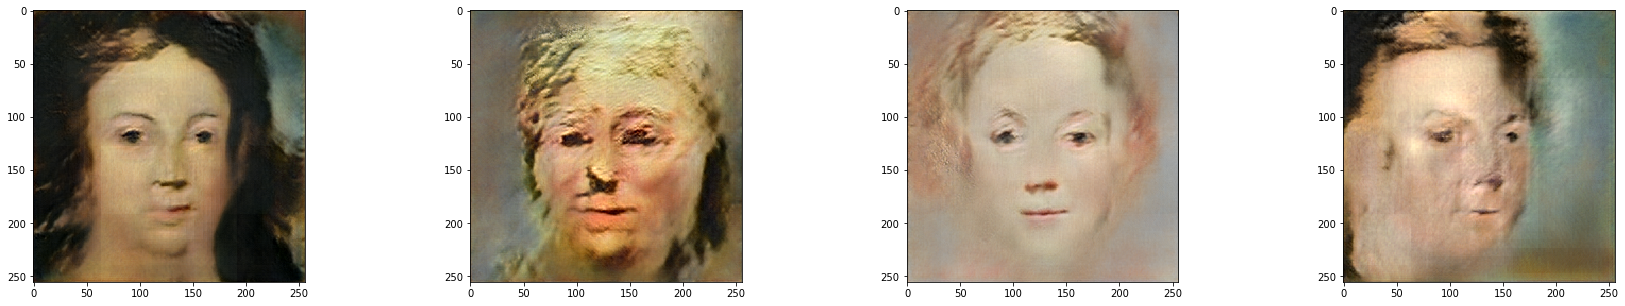

100%|██████████| 167/167 [01:12<00:00,  2.31it/s]


FID: 98.9574
Epoch: 0 | D Cost: 444.1160951256752 | GP Cost: 14.166955888271332 | G Cost: 320.1883134841919 | P(aug): 0.0 | Rt: 0.2305 | PPL Loss: 31.8444
Epoch: 1 | D Cost: 443.429767370224 | GP Cost: 13.512170821428299 | G Cost: 309.46194222569466 | P(aug): 0.0 | Rt: 0.2246 | PPL Loss: 31.4532
Epoch: 2 | D Cost: 439.8775137066841 | GP Cost: 12.74815320968628 | G Cost: 319.180727660656 | P(aug): 0.0 | Rt: 0.2395 | PPL Loss: 41.1203
Epoch: 3 | D Cost: 441.48269510269165 | GP Cost: 13.358254313468933 | G Cost: 310.81853860616684 | P(aug): 0.0 | Rt: 0.2388 | PPL Loss: 24.082
Epoch: 4 | D Cost: 440.2776427268982 | GP Cost: 13.187667310237885 | G Cost: 301.05865478515625 | P(aug): 0.0 | Rt: 0.2433 | PPL Loss: 21.2315
Training; 1055.0758 seconds to complete
/notebooks/faceGAN
/notebooks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.5402779
D(x) (higher = better disc): 0.6826731
D Loss: tf.Tensor(0.91098964, shape=(), dtype=float32)
G Loss: tf.Tensor(1.0211953, shape=(), dtype=float32)


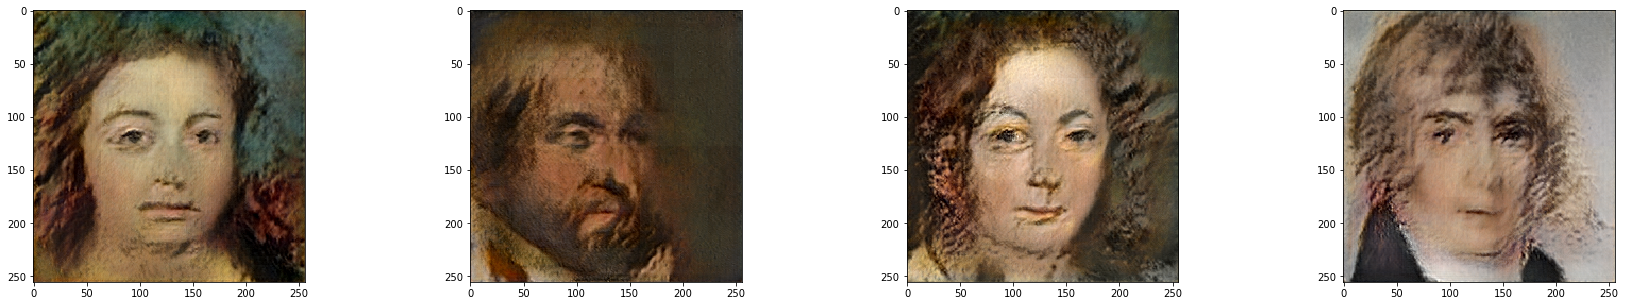

100%|██████████| 167/167 [01:10<00:00,  2.35it/s]


FID: 125.9426
Epoch: 0 | D Cost: 436.2501452565193 | GP Cost: 14.183193445205688 | G Cost: 310.9299682378769 | P(aug): 0.0 | Rt: 0.253 | PPL Loss: 25.5105
Epoch: 1 | D Cost: 434.2888497710228 | GP Cost: 13.524405002593994 | G Cost: 314.2189310789108 | P(aug): 0.0 | Rt: 0.2912 | PPL Loss: 27.4275
Epoch: 2 | D Cost: 434.9003911614418 | GP Cost: 13.9520805478096 | G Cost: 319.6400528848171 | P(aug): 0.0 | Rt: 0.2635 | PPL Loss: 28.5096
Epoch: 3 | D Cost: 433.4701792001724 | GP Cost: 14.085476517677307 | G Cost: 309.68843215703964 | P(aug): 0.0 | Rt: 0.253 | PPL Loss: 22.1357
Epoch: 4 | D Cost: 435.6303901672363 | GP Cost: 14.425763130187988 | G Cost: 310.1277213692665 | P(aug): 0.0 | Rt: 0.2485 | PPL Loss: 25.5874
Training; 1052.5365 seconds to complete
/notebooks/faceGAN
/notebooks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -0.92606086
D(x) (higher = better disc): 0.19675288
D Loss: tf.Tensor(1.0132743, shape=(), dtype=float32)
G Loss: tf.Tensor(1.2818832, shape=(), dtype=float32)


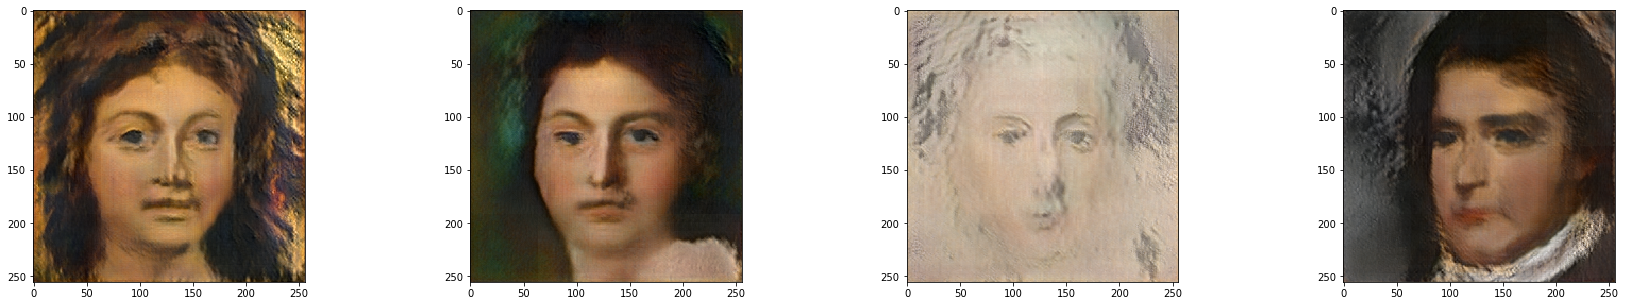

100%|██████████| 167/167 [01:11<00:00,  2.34it/s]


FID: 90.7277
Epoch: 0 | D Cost: 433.8317205309868 | GP Cost: 14.760727167129517 | G Cost: 306.1648631989956 | P(aug): 0.0 | Rt: 0.3114 | PPL Loss: 20.7279
Epoch: 1 | D Cost: 434.024282515049 | GP Cost: 13.521263062953949 | G Cost: 315.067941814661 | P(aug): 0.0 | Rt: 0.2844 | PPL Loss: 24.8379
Epoch: 2 | D Cost: 431.8665850162506 | GP Cost: 14.522767901420593 | G Cost: 333.9767664670944 | P(aug): 0.0 | Rt: 0.2747 | PPL Loss: 52.7415
Epoch: 3 | D Cost: 429.4924311041832 | GP Cost: 14.223509669303894 | G Cost: 336.95581102371216 | P(aug): 0.0 | Rt: 0.2919 | PPL Loss: 50.2534
Epoch: 4 | D Cost: 433.6243612766266 | GP Cost: 15.476030826568604 | G Cost: 313.8292106986046 | P(aug): 0.0 | Rt: 0.2844 | PPL Loss: 22.5112
Training; 1053.7743 seconds to complete
/notebooks/faceGAN
/notebooks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(G(z)) (lower = better disc): -1.0793991
D(x) (higher = better disc): 0.27104333
D Loss: tf.Tensor(0.9249033, shape=(), dtype=float32)
G Loss: tf.Tensor(1.3972013, shape=(), dtype=float32)


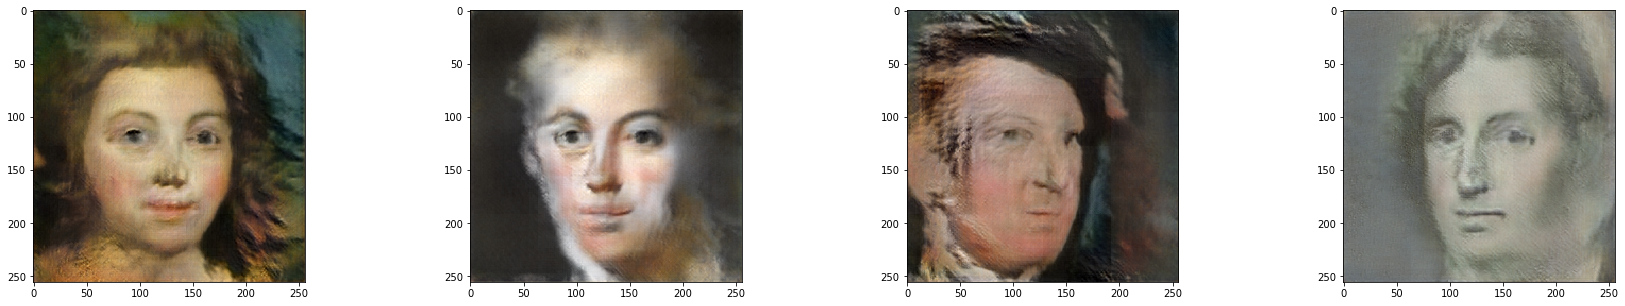

100%|██████████| 167/167 [01:11<00:00,  2.34it/s]


FID: 95.6593
Epoch: 0 | D Cost: 432.8175276517868 | GP Cost: 15.435008585453033 | G Cost: 319.0427465438843 | P(aug): 0.000512 | Rt: 0.2994 | PPL Loss: 31.5375
Epoch: 1 | D Cost: 436.2722446322441 | GP Cost: 14.880759835243225 | G Cost: 308.5293006300926 | P(aug): 0.0 | Rt: 0.247 | PPL Loss: 23.5201


In [ ]:
constZ = npr.randn(zdim,)
constNoise = npr.randn(imgSize, imgSize, 1)
epoch = 0

while True:
    if type(reals) != np.ndarray or type(ds) == type(None):
        loadData()
    
    sess = timeIt('Training')
    display(z1=npr.randn(rows * cols, zdim), z2=npr.randn(rows * cols, zdim), noise=npr.randn(rows * cols, imgSize, imgSize, 1), verbose=True)
    
    train(epochs=5)
    loadData()
    epoch += 1
    sess.close()
    save_models(askInp=False)

#### Visualize gradients

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


D(x): [[-1.0964804]] | D(G(z)): [[-5.854583]]
tf.Tensor(1.3875586, shape=(), dtype=float32)


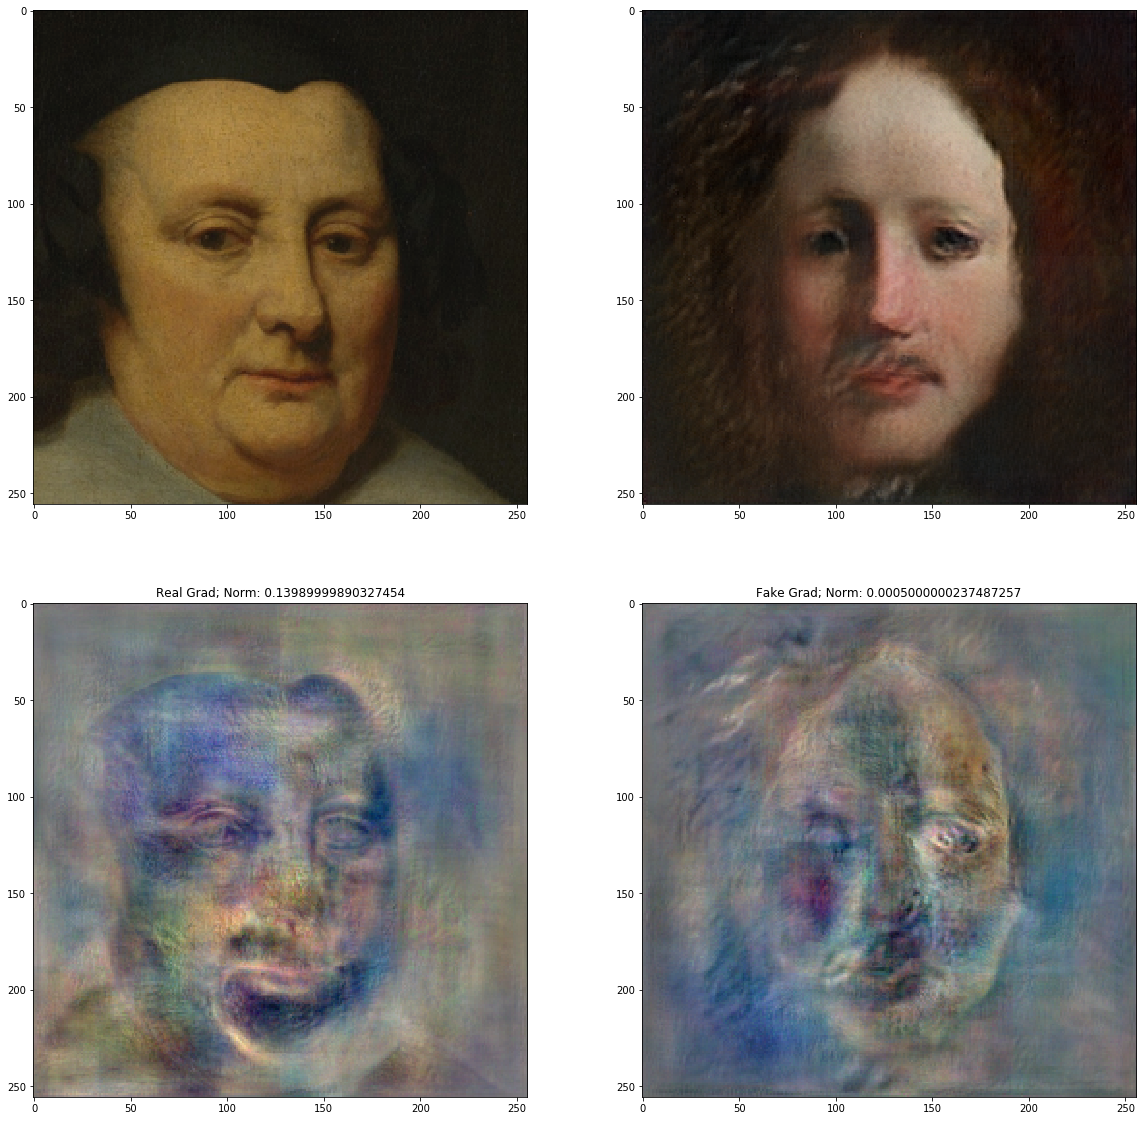

In [72]:
if type(reals) != np.ndarray or type(ds) == type(None):
    #loadData()
    reals = np.load(os.path.join(datasetPath, 'imgs.npy'))
    m = batchSize * (reals.shape[0] // batchSize)
    reals = reals[:m].astype(np.float32)

    assert reals.shape[0] % batchSize == 0
    assert type(reals) == np.ndarray
    ds = (tf.data.Dataset.from_tensor_slices(tf.cast(reals, tf.float32)).shuffle(3000).batch(batchSize))
    ds = ds.prefetch(AUTO)
    gc.collect()

dGrad, gGrad, dNorm, gNorm, img, fake, truePreds, fakePreds = retGrads()
print('D(x): {} | D(G(z)): {}'.format(truePreds, fakePreds))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
dGrad = (dGrad - np.min(dGrad)) / (np.max(dGrad) - np.min(dGrad) + eps)
gGrad = (gGrad - np.min(gGrad)) / (np.max(gGrad) - np.min(gGrad) + eps)
axes[0][0].imshow(img/2+0.5)
axes[0][1].imshow(fake/2+0.5)
axes[1][0].imshow(dGrad)
axes[1][0].set_title('Real Grad; Norm: {}'.format(round(dNorm, 4)))
axes[1][1].imshow(gGrad)
axes[1][1].set_title('Fake Grad; Norm: {}'.format(round(gNorm, 4)))
plt.show()

#### Visualize mapping activations

In [ ]:
z = npr.randn(1, zdim)
w = mapper.predict(z)
plt.imshow(z[0].reshape(16, 16))
plt.colorbar()
plt.show()
plt.imshow(w[0].reshape(16, 16))
plt.colorbar()
plt.show()

#### See generated images

In [ ]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)

'''
if z1s commented out, same content, different styles
if z2s commented out, different content, same styles
if noise = 0, undesirably smooth faces but just a test to make sure styles are working properly
'''
for i in range(5): 
    constZ1s = npr.randn(rows * cols, zdim)
    #constZ2s = npr.randn(rows * cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1) * 0
    display(z1=constZ1s, z2=constZ2s, noise=constNoises, verbose=False)

In [ ]:
try:
    constZ1s
except Exception as e:
    constZ1s = npr.randn(rows*cols, zdim)
    constZ2s = npr.randn(rows*cols, zdim)
    constNoises = npr.randn(rows * cols, imgSize, imgSize, 1)
    
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(30, 15))

z1 = constZ1s; z2 = constZ2s; noise = constNoises

randInds = npr.randint(0, reals.shape[0], (rows*cols,))

w1 = z1; w2 = z2
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[0][i].imshow(preds[i] / 2 + 0.5)
    
w1 = mapper(z1, training=False)
w2 = mapper(z2, training=False)
ws = [w1 for i in range(3)] + [w2 for i in range(4)]
preds = generator([*ws, noise], training=False)

for i in range(cols):
    axes[1][i].imshow(preds[i] / 2 + 0.5)

plt.show()

#### See metrics over training

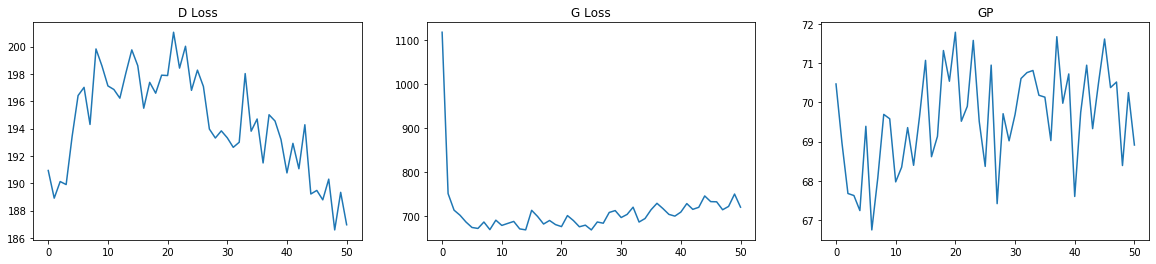

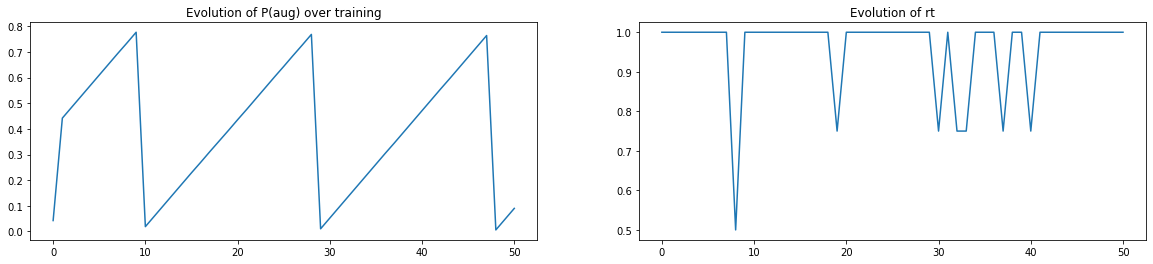

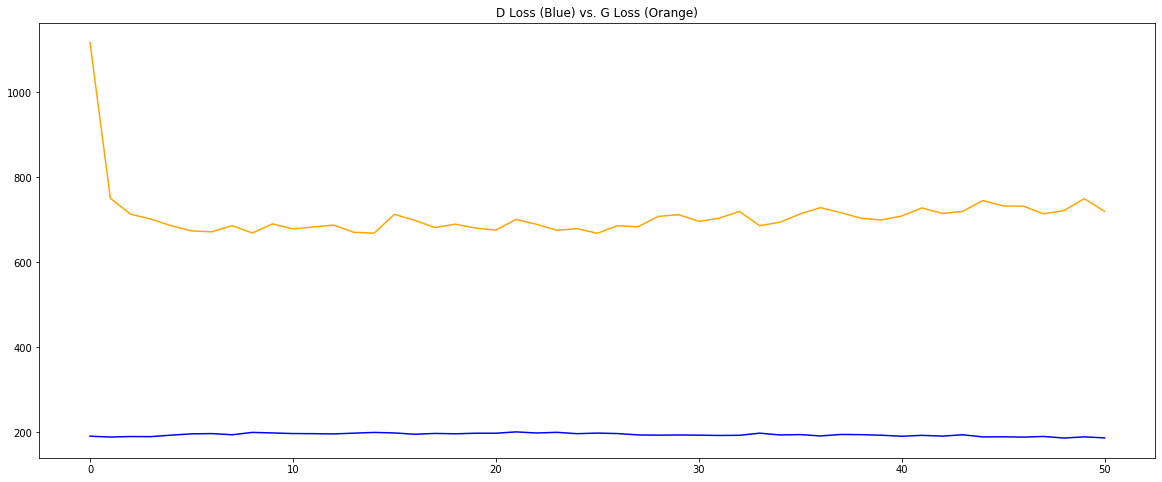

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
pltX = range(len(dcosts))
axes[0].plot(pltX, dcosts); axes[0].set_title('D Loss')
axes[1].plot(pltX, gcosts); axes[1].set_title('G Loss')
axes[2].plot(pltX, gpcosts); axes[2].set_title('GP')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
axes[0].plot(pltX, ps); axes[0].set_title('Evolution of P(aug) over training')
axes[1].plot(pltX, rts); axes[1].set_title('Evolution of r_t')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
axes.set_title('D Loss (Blue) vs. G Loss (Orange)')
axes.plot(pltX, dcosts, color='blue')
axes.plot(pltX, gcosts, color='orange')
plt.show()

#### Epilogue

In [ ]:
save_models(askInp=True)

In [ ]:
import gc

gc.collect()
K.clear_session()
#del generator, discriminator, mapper